# Test implementation QRNN

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np


# Plotting
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)

In [3]:
seed_everything(0)

## Dataset loading

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../../../../../../../../Downloads/quantum_data/mc_train_data.txt')
dev_labels, dev_data = read_data('../../../../../../../../Downloads/quantum_data/mc_dev_data.txt')
test_labels, test_data = read_data('../../../../../../../../Downloads/quantum_data/mc_test_data.txt')

In [5]:
# From one-hot to integer
train_labels = np.argmax(train_labels, 1)
dev_labels = np.argmax(dev_labels, 1)
test_labels = np.argmax(test_labels, 1)

## Word2vec

In [6]:
import gensim.downloader

# Load the model from gensim-data
glove_model = gensim.downloader.load('glove-twitter-25')


In [7]:
#Get the word embeddings for each word in the sentence
def get_word_embeddings(sentence, seq_length):
    embeddings = []
    for word in sentence.split():
        try:
            embeddings.append(glove_model[word])
        except:
            pass

    #Pad the array with zeros if the sentence is shorter than the max length
    if len(embeddings) < seq_length:
        embeddings.extend(np.zeros((seq_length-len(embeddings), 25)))
    return np.array(embeddings)

In [8]:
def preprocess_dataset(data, seq_length):
    new_data = []
    for sentence in data:
        new_data.append(get_word_embeddings(sentence, seq_length))
    return np.array(new_data)

In [9]:
def find_max_length(data):
    max_length = 0
    for sentence in data:
        if len(sentence.split()) > max_length:
            max_length = len(sentence.split())
    return max_length

In [10]:
seq_length = np.max([find_max_length(train_data), find_max_length(dev_data), find_max_length(test_data)])

In [11]:
X_train = preprocess_dataset(train_data, seq_length)
X_dev = preprocess_dataset(dev_data, seq_length)
X_test = preprocess_dataset(test_data, seq_length)

In [12]:
class EmbeddingDataset(Dataset):
    """Embedding dataset."""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.tensor(self.X[idx]).to(torch.float32) , torch.tensor(self.Y[idx]).to(torch.float32)

## Setting of the main hyper-parameters of the model

### To implement this circuit, we need ancilla qubits. 
For the Reg_D part we need X*max_sentence_len qubits and for the Reg_H part we need X qubits.


Here we have X = 3 and max_sentence_len = 5


Thus n_qubits = 3*5 + 3 = 18

In [13]:
n_qubits_D = 3                # Number of qubits for the Reg_D
n_qubits_H = 3                # Number of qubits for the Reg_H
# In the paper n_qubits_D = n_qubits_H = 3

n_qubits = seq_length*n_qubits_D + n_qubits_H   # Number of qubits

In [14]:
BATCH_SIZE = 1024
EPOCHS = 50
LR = 2e-1
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20
WEIGHT_DECAY = 0

In [15]:
dev = qml.device("default.qubit", wires=n_qubits)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Pennylane doesnt seem to support Mac Apple Silicon yet
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print('Device used:', device)


Device used: cpu


## Variational quantum circuit


In [17]:
def RZZ_block(wires, weight):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(weight, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

In [18]:
def regD(x_t, weights):
    # Here we can modify only the first n_qubits_D wires

    # Embed features in the quantum node
    for idx, element in enumerate(x_t):
        qml.RY(element, wires=idx)

    ## First part of the circuit
    for idx, element in enumerate(weights[0]):
        qml.RX(element, wires=idx)

    for idx, element in enumerate(weights[1]):
        qml.RZ(element, wires=idx)

    for idx, element in enumerate(weights[2]):
        qml.RX(element, wires=idx)


In [19]:
def regH(weights):
    # Here we can modify only the wires from n_qubits_D to n_qubits_D + n_qubits_H

    ## First part of the circuit
    for idx, element in enumerate(weights[0]):
        qml.RX(element, wires=n_qubits_D+idx)

    for idx, element in enumerate(weights[1]):
        qml.RZ(element, wires=n_qubits_D+idx)

    for idx, element in enumerate(weights[2]):
        qml.RX(element, wires=n_qubits_D+idx)


In [20]:
@qml.qnode(dev, interface="torch")
def regD_H(inputs, weights_start_D, weights_start_H, weights_entangle):
    inputs = inputs.reshape((seq_length, n_qubits_D))

    for index, x_t in enumerate(inputs):
        # Here word is a 1 dimensional vector, (X/2)
        regD(x_t, weights_start_D)
    
        regH(weights_start_H)

    
        # Entanglement
        for idx, element in enumerate(weights_entangle[:-1]):
            RZZ_block([idx, idx + 1], element)

        # Entanglement between the last Reg_H and the first Reg_D qubit
        RZZ_block([n_qubits_D + n_qubits_H - 1, 0], weights_entangle[-1])

        if index < seq_length - 1:
            # SWAP the reg_D qubits with the ancilla qubits
            for idx in range(n_qubits_D):
                qml.SWAP(wires=[idx, n_qubits_D + n_qubits_H + index*n_qubits_D + idx])


    #We measure the 1st qubit
    exp_vals_Y = qml.expval(qml.PauliY(0))

    #We measure the 2nd qubit to reset its state to 0
    #_ = qml.expval(qml.PauliY(1))

    #print(exp_vals_Y)

    #print(type(exp_vals_Y))

    #exp_vals_Z = [qml.expval(qml.PauliZ(position)) for position in range(2)]

    #print(exp_vals_Z)

    #print(type(exp_vals_Z))
    #print(tuple(exp_vals_Z))
    #print(torch.hstack(tuple(exp_vals_Z)))

    #return torch.tensor([exp_vals_Y])
    return exp_vals_Y

In [21]:
def regD_batch(weights):
    # Here we can modify only the first n_qubits_D wires

    ## First part of the circuit
    for idx, element in enumerate(weights[0]):
        qml.RX(element, wires=idx)

    for idx, element in enumerate(weights[1]):
        qml.RZ(element, wires=idx)

    for idx, element in enumerate(weights[2]):
        qml.RX(element, wires=idx)


In [22]:
@qml.batch_input
@qml.qnode(dev, interface="torch")
def regD_H_batch(sentence, weights_start_D, weights_start_H, weights_entangle):
    print(sentence.shape)

    
    embedding_range = list(range(n_qubits_D)) + list(range(n_qubits_D + n_qubits_H, n_qubits))

    
    qml.AngleEmbedding(sentence, wires=embedding_range, rotation="Y")


    for index, x_t in enumerate([0, 1, 2, 3, 4]):
        # Here word is a 1 dimensional vector, (X/2)
        regD_batch(weights_start_D)
    
        regH(weights_start_H)

    
        # Entanglement
        for idx, element in enumerate(weights_entangle[:-1]):
            RZZ_block([idx, idx + 1], element)

        # Entanglement between the last Reg_H and the first Reg_D qubit
        RZZ_block([n_qubits_D + n_qubits_H - 1, 0], weights_entangle[-1])

        if index < seq_length - 1:
            # SWAP the reg_D qubits with the ancilla qubits
            for idx in range(n_qubits_D):
                qml.SWAP(wires=[idx, n_qubits_D + n_qubits_H + index*n_qubits_D + idx])

        


    #We measure the 1st qubit
    
    exp_vals_Y = qml.expval(qml.PauliY(0))
    print("oula")
    #pdb.set_trace()
    return exp_vals_Y

In [43]:
def regD_H_BATCH2(inputs, weights_start_D, weights_start_H, weights_entangle):
    inputs = inputs.reshape((seq_length, n_qubits_D))

    for index, x_t in enumerate(inputs):
        # Here word is a 1 dimensional vector, (X/2)
        regD(x_t, weights_start_D)
    
        regH(weights_start_H)

    
        # Entanglement
        for idx, element in enumerate(weights_entangle[:-1]):
            RZZ_block([idx, idx + 1], element)

        # Entanglement between the last Reg_H and the first Reg_D qubit
        RZZ_block([n_qubits_D + n_qubits_H - 1, 0], weights_entangle[-1])

        if index < seq_length - 1:
            # SWAP the reg_D qubits with the ancilla qubits
            for idx in range(n_qubits_D):
                qml.SWAP(wires=[idx, n_qubits_D + n_qubits_H + index*n_qubits_D + idx])


    #We measure the 1st qubit
    exp_vals_Y = qml.expval(qml.PauliY(0))

    return exp_vals_Y

In [44]:
class DressedQuantumNet_Batch(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(25, n_qubits_D)
        self.q_params_start_D = nn.Parameter(torch.randn((3, n_qubits_D)), requires_grad=True)
        self.q_params_start_H = nn.Parameter(torch.randn((3, n_qubits_H)), requires_grad=True)

        self.q_params_entangle = nn.Parameter(torch.randn((n_qubits_D+n_qubits_H, 1)), requires_grad=True)
        self.sigmoid = nn.Sigmoid()

        dev = qml.device('default.qubit', wires=n_qubits)
        
        self.quantum_net = qml.QNode(regD_H_BATCH2, dev, interface="torch")

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 3
        pre_out = self.pre_net(input_features)
        #q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_in = torch.sigmoid(pre_out) * np.pi

        print('q_in.shape: ', q_in.shape)
        y_hat = self.quantum_net(q_in, self.q_params_start_D, self.q_params_start_H, self.q_params_entangle)
        
        y_hat = self.q_layer(q_in)
        #q_out = y_hat

        return self.sigmoid(y_hat)

In [45]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(25, n_qubits_D)
        self.q_params_start_D = nn.Parameter(torch.randn((3, n_qubits_D)), requires_grad=True)
        self.q_params_start_H = nn.Parameter(torch.randn((3, n_qubits_H)), requires_grad=True)

        self.q_params_entangle = nn.Parameter(torch.randn((n_qubits_D+n_qubits_H, 1)), requires_grad=True)
        self.sigmoid = nn.Sigmoid()

        self.q_layer = qml.qnn.TorchLayer(regD_H, {"weights_start_D": (3, n_qubits_D),
                                                    "weights_start_H": (3, n_qubits_H),
                                                    "weights_entangle": (n_qubits_D+n_qubits_H, 1)})

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 3
        pre_out = self.pre_net(input_features)
        #q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_in = torch.sigmoid(pre_out) * np.pi


        
        #q_out = torch.Tensor(0, 1)
        #q_out = q_out.to(device)
        # for sentence in q_in:
        #     #Here sentence is a 2 dimensional vector, (seq_length, X/2) with X --> Number of qubits for Reg_D
        #     #for word in sentence:
        #         #y_hat = torch.tensor([regD_H(word, self.q_params_start, self.q_params_entangle)])
        #     y_hat = regD_H(sentence, self.q_params_start_D, self.q_params_start_H, self.q_params_entangle)

        #     #After the execution of the QC, all the qubits are reset to the |0> state


        #     #We only keep the last measured y_hat
        #     q_out = torch.cat((q_out, y_hat.reshape(1, 1)), dim=0)
        
        # We flatten the input to be able to use the batch processing of the quantum circuit, shape expected (batch_size, x)
        q_in = q_in.flatten(1)
        
        y_hat = self.q_layer(q_in)
        #q_out = y_hat

        return self.sigmoid(y_hat)

In [46]:
train_dataset = EmbeddingDataset(X_train, train_labels)
training_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = EmbeddingDataset(X_dev, dev_labels)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = EmbeddingDataset(X_test, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [47]:
#model_hybrid = DressedQuantumNet()
model_hybrid = DressedQuantumNet_Batch()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results

Here we use a Binary Cross Entropy Loss, an Adam optimizer and a scheduler reducing the learning rate at an exponentially rate. 

In [48]:
criterion = nn.BCELoss()

optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=STEP_LR, gamma=GAMMA_LR
)

#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(
#    optimizer_hybrid, T_max=EPOCHS, eta_min=1e-5)



We use tensorboard to log the hyperparameters, the loss and the accuracy of the model:

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/test_QRNN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [49]:
#Training loop
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []
print("Training started:")

epoch_bar = tqdm(range(EPOCHS), total=EPOCHS, desc="Epochs", position=0, leave=True)

for epoch in epoch_bar:

    model_hybrid.train()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    it = 0
    training_bar = tqdm(training_dataloader, total=len(training_dataloader), desc="Training", position=0, leave=True)

    for inputs, labels in training_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(True):
            outputs = model_hybrid(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            
            
            loss.backward()
            optimizer_hybrid.step()

        # Print iteration results
        running_loss += loss.item()*batch_size_

        batch_corrects = torch.sum(preds == labels.unsqueeze(1)).item()
        running_corrects += batch_corrects

        training_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})


    # Print epoch results
    train_loss = running_loss / len(training_dataloader.dataset)
    train_acc = running_corrects / len(training_dataloader.dataset)

    epoch_bar.set_postfix({"loss": f"{train_loss:.3f}", "acc": f"{train_acc:.3f}"})

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)

    exp_lr_scheduler.step()

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    
    ## VALIDATION PHASE
    validation_bar = tqdm(dev_dataloader, total=len(dev_dataloader), desc="Validation", position=0, leave=True)
    model_hybrid.eval()

    running_loss = 0.0
    running_corrects = 0


    for inputs, labels in validation_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(False):
            outputs = model_hybrid(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1))

        # Print iteration results
        running_loss += loss.item()*batch_size_
        batch_corrects = torch.sum(preds == labels.unsqueeze(1)).item()
        running_corrects += batch_corrects

        validation_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})
        it += 1

    validation_loss = running_loss / len(dev_dataloader.dataset)
    validation_acc = running_corrects / len(dev_dataloader.dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    if validation_acc > best_val_acc:
        best_val_acc = validation_acc

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss



Training started:


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

q_in.shape:  torch.Size([70, 5, 3])


RuntimeError: shape '[5, 3]' is invalid for input of size 1050

In [ ]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR, 'weight_decay': WEIGHT_DECAY},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

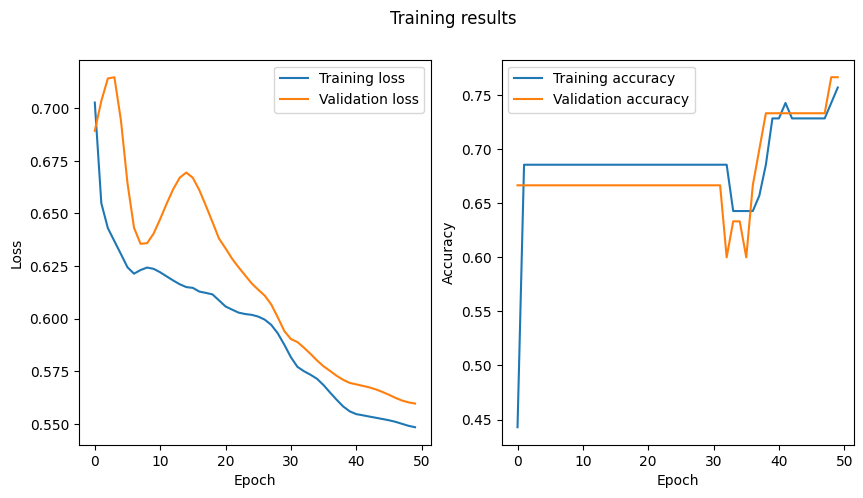

In [ ]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)

In [ ]:
#TEST STUFF

In [ ]:
dev2 = qml.device("default.qubit", wires=4)

In [ ]:
@qml.qnode(dev2, interface="torch")
def qc_2(x_t):

    
    for idx, element in enumerate(x_t):
        qml.RY(element, wires=idx)

    ## First part of the circuit
    for idx, element in enumerate(x_t):
        qml.RX(element, wires=idx)

    #qml.QubitStateVector(np.array([1, 0, 0, 0]), wires=range(2))
    #qml.BasisState(np.array([0, 0]), wires=range(2))


    qml.SWAP(wires=[0, 3])

    #We measure the 1st qubit
    exp_vals_Y = qml.expval(qml.PauliY(0))
    exp_vals_Y2 = qml.expval(qml.PauliY(1))



    

    
    #We measure the 2nd qubit to reset its state to 0
    #_ = qml.expval(qml.PauliY(1))

    #print(exp_vals_Y)

    #print(type(exp_vals_Y))

    #exp_vals_Z = [qml.expval(qml.PauliZ(position)) for position in range(2)]

    #print(exp_vals_Z)

    #print(type(exp_vals_Z))
    #print(tuple(exp_vals_Z))
    #print(torch.hstack(tuple(exp_vals_Z)))

    #return torch.tensor([exp_vals_Y])
    return exp_vals_Y, exp_vals_Y2

In [ ]:
word = torch.Tensor([0.1, 0.2])

In [ ]:
out = qc_2(word)
out

(tensor(0., dtype=torch.float64), tensor(-0.1947, dtype=torch.float64))

In [ ]:
def qc_3():
    #We measure the 1st qubit
    #qml.RX(0.1, wires=0)
    
    exp_vals_Y = qml.expval(qml.PauliY(1))

    return exp_vals_Y

In [ ]:
qml.expval(qml.PauliY(1))

expval(PauliY(wires=[1]))

In [ ]:
qc_3()

expval(PauliY(wires=[1]))

In [ ]:
qc_2(word), qc_3()

(expval(PauliY(wires=[0])), expval(PauliY(wires=[1])))

In [ ]:
qnode = qml.QNode(qc_3, dev2)


In [ ]:
qnode()

tensor(0., requires_grad=True)

In [ ]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface="torch")
def circuit(inputs, weights):
    qml.RY(weights[0], wires=0)
    qml.AngleEmbedding(inputs, wires=range(2), rotation="Y")
    qml.RY(weights[1], wires=1)
    return qml.expval(qml.PauliZ(1))

In [ ]:
x = torch.randn((10, 2))
w = torch.randn((2,))
circuit(x, w)

tensor([-0.0592, -0.6528,  0.9409,  0.6634,  0.7186, -0.4953,  0.1785,  0.6722,
         0.9934, -0.4236], dtype=torch.float64)

In [ ]:
x.shape

TensorShape([10, 2])

In [ ]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit2(features):
    print(features.shape)
    print(features[0].shape)
    qml.AngleEmbedding(features[0], wires=range(2))
    qml.AngleEmbedding(features[1], wires=range(2))
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

batch1 = [0.1, 0.2]
batch2 = [0.1, 0.2]
batches = [batch1, batch2]

batches2 = [[0.2, 0.4], [0.6, 0.8]]
batchesbatches= np.array([batches, batches2])

batchesbatches = torch.tensor(batchesbatches)

print(circuit2(batchesbatches))
print(dev.num_executions)

torch.Size([2, 2, 2])
torch.Size([2, 2])
[tensor([0.9553, 0.7648], dtype=torch.float64), tensor([0.8253, 0.5403], dtype=torch.float64)]
1


In [ ]:
batchesbatches.shape


torch.Size([2, 2, 2])

In [ ]:
inputs2.shape

torch.Size([70, 5, 3])

In [ ]:
def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RZ_layer(w):
    """Layer of parametrized qubit rotations around the z axis.
    """
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

In [ ]:
def circuit3(inputs, q_weights):
    #https://onlinelibrary.wiley.com/doi/epdf/10.1002/qute.201900070
    #Circuit [6] but adapted for n_qubits = 3

    print(inputs.shape)

    op = qml.AngleEmbedding(features=inputs, wires=range(n_qubits), rotation='X')

    print(op.batch_size)

    #RX_layer(inputs)

    parameter_index = 0
    
    #RZ_layer(q_weights[parameter_index : parameter_index+n_qubits])
    for idx, element in enumerate(q_weights[parameter_index : parameter_index+n_qubits]):
        print(idx)
        qml.RZ(element, wires=idx)

    parameter_index += n_qubits

    for k in range(0, n_qubits):
        for j in range(0, n_qubits):
            if k != j:
                qml.CRX(phi=q_weights[parameter_index], wires=[k, j])
                parameter_index += 1

    #RX_layer(q_weights[parameter_index : parameter_index+n_qubits])
    for idx, element in enumerate(q_weights[parameter_index : parameter_index+n_qubits]):
        qml.RX(element, wires=idx)
    parameter_index += n_qubits

    #RZ_layer(q_weights[parameter_index : parameter_index+n_qubits])
    for idx, element in enumerate(q_weights[parameter_index : parameter_index+n_qubits]):
        qml.RZ(element, wires=idx)
    parameter_index += n_qubits

    exp_vals_Y = [qml.expval(qml.PauliY(position)) for position in range(n_qubits)]

    print(exp_vals_Y)
    print(tuple(exp_vals_Y))

    print('LETS GOOOOOO')
    return exp_vals_Y


    

In [ ]:
n_qubits = 3
dev = qml.device('default.qubit', wires=n_qubits)

quantum_net = qml.QNode(circuit3, dev, interface="torch")

q_params = nn.Parameter(torch.randn((n_qubits + 2) * n_qubits))
q_in = torch.ones((80, 3))

In [ ]:
q_out = quantum_net(q_in, q_params)

torch.Size([80, 3])
80
0
1
2
[expval(PauliY(wires=[0])), expval(PauliY(wires=[1])), expval(PauliY(wires=[2]))]
(expval(PauliY(wires=[0])), expval(PauliY(wires=[1])), expval(PauliY(wires=[2])))
LETS GOOOOOO


In [ ]:
q_out = torch.stack(q_out)
q_out = q_out.reshape((q_out.shape[1], q_out.shape[0]))

In [ ]:
q_out.shape

torch.Size([80, 3])

In [ ]:
torch.tensor(tuple(q_out)[0])

/var/folders/6f/3fhw90n17t140lh7zgl3n7080000gq/T/ipykernel_88765/3422026163.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tuple(q_out)[0])


tensor([-0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425],
       dtype=torch.float64)

In [ ]:
q_out[0]

tensor([-0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425,
        -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425, -0.2425],
       dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)

In [ ]:
q_out.__len__()

3

In [ ]:
q_out[0].shape

torch.Size([80])